In [ ]:
# Just to download the dataset

!pip install ucimlrepo -q

In [45]:
# imports

import seaborn as sns
from ucimlrepo import fetch_ucirepo
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Task: 1

In [46]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
#print(heart_disease.metadata)

# variable information
#print(heart_disease.variables)

In [47]:
for column in X.columns:
    try:
        X.loc[:, column] = X[column].astype(float)
    except ValueError:
        print(f"Cannot convert values in column '{column}' to float.")

for column in y.columns:
    try:
        y.loc[:, column] = y[column].astype(float)
    except ValueError:
        print(f"Cannot convert values in column '{column}' to float.")

In [48]:
print(X.head())
print("\n")
print(y.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  
0  0.0   6.0  
1  3.0   3.0  
2  2.0   7.0  
3  0.0   3.0  
4  0.0   3.0  


   num
0    0
1    2
2    1
3    0
4    0


In [49]:
null_values = X.isnull().sum()
# print(null_values) ==> null values: ca=4, thal=2

# To get the names of columns with NaN values
features_with_nan = null_values[null_values > 0].index

# To drop rows with NaN values
#X = X.dropna(subset=features_with_nan)
#y = y.loc[X.index]

# Fill NaN values with the median
for feature in features_with_nan:
    X.loc[:, feature] = X[feature].fillna(X[feature].median())

In [51]:
print("Features (Independent Variables): ", list(X.columns))
print("Target (Dependent Variable): ", list(y.columns))

Features (Independent Variables):  ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Target (Dependent Variable):  ['num']


We don't want to lose the data in rows with any NaN value but also when we fill it, we don't want to manipulate it's correlation with target so we checked a few different combinations to see which one serves our aim.

**Strong Correlations with Target:**

fillna with mean|fillna with 0|fillna with median|dropna
----------------|-------------|------------------|-----------
ca: [0.51739019]|ca: [0.52096809]| ca: [0.52096809]| ca: [0.52117844]
thal: [0.50879851]|thal: [0.49823784]| thal: [0.50715467]| thal: [0.51337703]

So we decided to use median to fill the nan values.




# Task: 2

In [52]:
def pearson_correlation(x, y):
    if len(x) != len(y):
        raise ValueError("Arrays must have the same length.")

    n = len(x)
    sum_x = sum(x)
    sum_y = sum(y)
    sum_xy = sum(x[i] * y[i] for i in range(n))
    sum_x_squared = sum(x[i] ** 2 for i in range(n))
    sum_y_squared = sum(y[i] ** 2 for i in range(n))

    numerator = (n * sum_xy) - (sum_x * sum_y)
    denominator = ((n * sum_x_squared - sum_x ** 2) * (n * sum_y_squared - sum_y ** 2)) ** 0.5

    if denominator == 0:
        raise ValueError("Denominator is zero; cannot compute Pearson correlation.")

    return (numerator / denominator)

In [53]:
correlation_dict = {}

# Pearson correlation Calculation
for feature in X.columns:
    correlation = pearson_correlation(X[feature].values, y.values)
    correlation_dict[feature] = correlation

# Display the results
print("Feature correlations with target variable:")
for feature, correlation in correlation_dict.items():
    print(f"{feature}: {correlation}")

Feature correlations with target variable:
age: [0.22285342]
sex: [0.22446851]
cp: [0.40707542]
trestbps: [0.15775408]
chol: [0.07090876]
fbs: [0.05918609]
restecg: [0.18369635]
thalach: [-0.41504046]
exang: [0.3970573]
oldpeak: [0.50409197]
slope: [0.3779566]
ca: [0.52096809]
thal: [0.50715467]


In [54]:
threshold = 0.3
strong_correlations = {feature: correlation for feature, correlation in correlation_dict.items() if abs(correlation) > threshold}

print("Strong Correlations with Target:")
for feature, correlation in strong_correlations.items():
    print(f"{feature}: {correlation}")

Strong Correlations with Target:
cp: [0.40707542]
thalach: [-0.41504046]
exang: [0.3970573]
oldpeak: [0.50409197]
slope: [0.3779566]
ca: [0.52096809]
thal: [0.50715467]


In [55]:
most_correlated_feature = max(strong_correlations, key=lambda k: abs(strong_correlations[k]))
most_correlated_value = strong_correlations[most_correlated_feature]

print("Most Correlated Feature:")
print(f"{most_correlated_feature}: {most_correlated_value}")

# We examine the correlation between features and the target to identify features that have a strong relationship with the target.
# Selecting the most correlated features can improve the model's performance by focusing on relevant data, which enhances accuracy and reduces complexity.


Most Correlated Feature:
ca: [0.52096809]


In the process of feature selection in this task, we selected features that had strong correlations—features with a correlation above 0.3—to provide a better approach in enhancing the performance of the regression model with optimal predictive features. The highest correlation was from the feature "ca" at 0.52, showing how highly relevant it is to the target variable. This approach usually helps in improving accuracy and interpretability by reducing noise. However, this might not capture complex interactions; therefore, although this model is relatively appropriate for data based on linear relationships, further testing is advised.

# Task: 3

In [56]:
def linear_regression(x,y):
  if len(x) != len(y):
    raise ValueError("Arrays must have the same length.")

  n = len(x)
  x_mean = sum(x)/ n
  y_mean = sum(y) / n

  numerator = sum((x[i] - x_mean) * (y[i] - y_mean)  for i in range(n))
  denominator = sum((x[i] - x_mean) ** 2  for i in range(n))
  if denominator == 0:
        raise ValueError("Denominator is zero; cannot compute b1.")

  b1 = numerator / denominator #slope
  b0 = y_mean - (b1 * x_mean) #intercept

  return b0, b1

In [57]:
b0, b1 = linear_regression(X[most_correlated_feature].values, y.values)
print(f"Intercept (b0): {b0}")
print(f"Slope (b1): {b1}")

Intercept (b0): [0.48290149]
Slope (b1): [0.68497935]


In [58]:
predictions = [b0 + (b1 * x) for x in X[most_correlated_feature]]

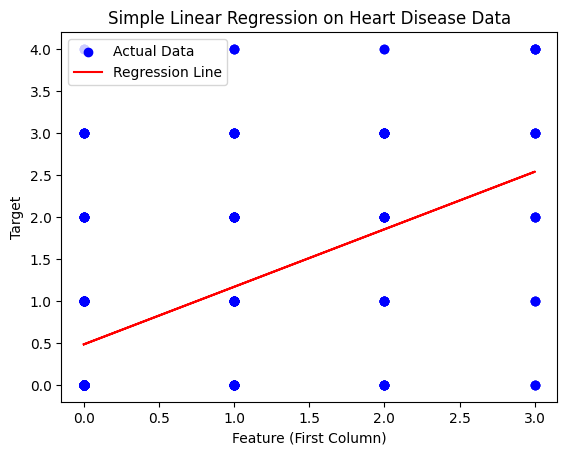

In [59]:
plt.scatter(X[most_correlated_feature].values, y.values, color='blue', label='Actual Data')
plt.plot(X[most_correlated_feature].values, predictions, color='red', label='Regression Line')
plt.xlabel("Feature (First Column)")
plt.ylabel("Target")
plt.title("Simple Linear Regression on Heart Disease Data")
plt.legend()
plt.show()

Here, we used a simple linear regression on feature ca to make a prediction of the target. The actual data points were so spread that the regression line showed only some basic trend. This limited the accuracy, hence indicating that the relationship may not be captured by such a simple linear model. All in all, even though this feature is a good starting point, it may be necessary to involve additional features to help us in better predictive performance.

# Task: 4

In [60]:
def multiple_linear_regression(X, y):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    # Regression coefficients calculation
    beta = (np.linalg.inv(X_b.T.dot(X_b))).dot(X_b.T).dot(y)
    return beta

# Sort features
sorted_features = sorted(correlation_dict, key=lambda k: abs(correlation_dict[k]), reverse=True)
top_features = sorted_features[:5]

print("Top 5 most correlated features with target:")
for feature in top_features:
    print(f"{feature}: {correlation_dict[feature]}")

Top 5 most correlated features with target:
ca: [0.52096809]
thal: [0.50715467]
oldpeak: [0.50409197]
thalach: [-0.41504046]
cp: [0.40707542]


In [61]:
# Top 5 features
X_top = X[top_features].values

# Regression Coefficient Calculation
beta = multiple_linear_regression(X_top, y.values)
print("Regression coefficients (beta):")
print(beta)

Regression coefficients (beta):
[[-0.16879747]
 [ 0.40346453]
 [ 0.16891934]
 [ 0.25856172]
 [-0.00630598]
 [ 0.22647352]]


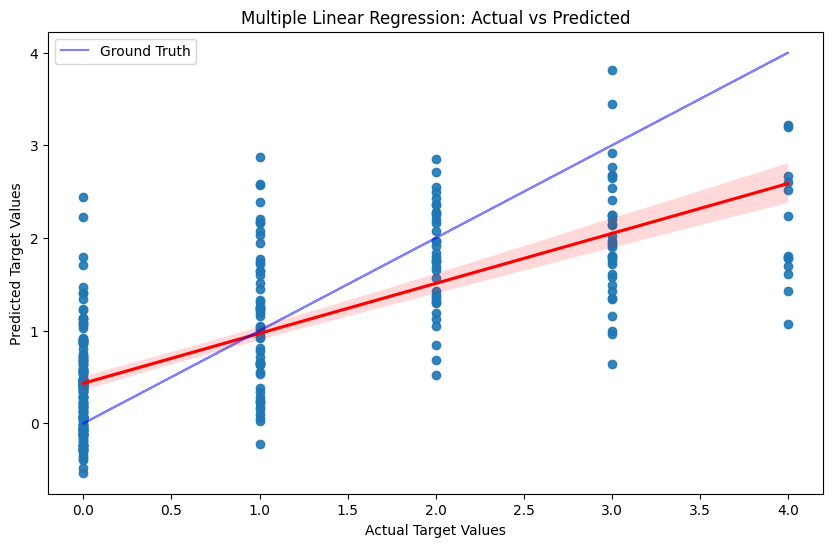

In [62]:
# Prediction
X_b_top = np.c_[np.ones((X_top.shape[0], 1)), X_top]
predictions = X_b_top.dot(beta)

# Visualization
plt.figure(figsize=(10, 6))
sns.regplot(x=y.values.ravel(), y=predictions.ravel(), scatter_kws={'alpha':0.9}, line_kws={'color': 'red'})  # Predicted Regression Line

# Ground Truth Regression Line
plt.plot(y.values.ravel(), y.values.ravel(), color='blue', label='Ground Truth', alpha=0.5)

plt.xlabel("Actual Target Values")
plt.ylabel("Predicted Target Values")
plt.title("Multiple Linear Regression: Actual vs Predicted")
plt.legend()
plt.show()

In [63]:
# MSE Calculation
mse = np.mean((y.values - predictions) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.6934986361151324


In this exercise, we used multiple linear regression with the top 5 most highly correlated features (ca, thal, oldpeak, thalach, cp) for target prediction. The regression coefficient of the model indicates the importance of each feature. The Mean Squared Error of 0.6934 reflects a medium level of prediction error, which relates to some captured patterns in data while keeping relevant room for enhancement. This is further supported by the spread in the predicted vs. actual plot, reflecting variability in the data not captured by this model. It may be improved with more features or more sophisticated modeling.

# Task: 5

Logistic Regression Model Accuracy: 57.14%



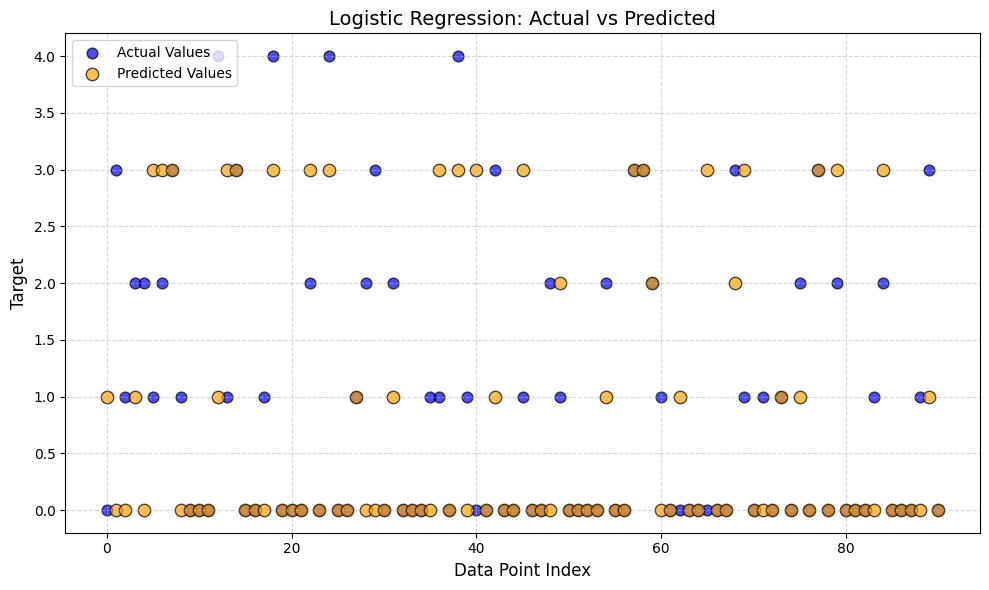

We also wanted to visualize our accuracy using confusion matrix
(for a better visualization and understanding):


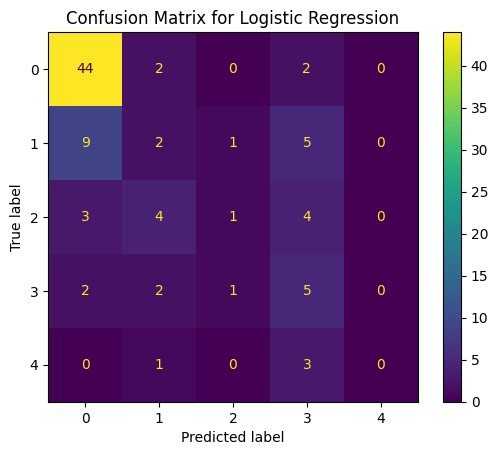

In [64]:
# Top 5 features
X_logistic = X[top_features]
y_logistic = y.copy()

# Feature scaling
scaler = StandardScaler()
X_logistic_scaled = scaler.fit_transform(X_logistic)

# Data splitting
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_logistic_scaled, y_logistic, test_size=0.3, random_state=42)

# Training
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_log, y_train_log.values.ravel())

# Model Evaluation
y_pred_log = logistic_model.predict(X_test_log)
correct_predictions = sum(y_pred_log == y_test_log.values.ravel())
total_predictions = len(y_test_log)
accuracy = correct_predictions / total_predictions
print(f"Logistic Regression Model Accuracy: {accuracy * 100:.2f}%\n")

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_log)), y_test_log, color='blue', edgecolor='black', alpha=0.7, label='Actual Values', s=60, marker='o')
plt.scatter(range(len(y_test_log)), y_pred_log, color='orange', marker='o', s=80, edgecolor='black', alpha=0.7, label='Predicted Values')

plt.xlabel("Data Point Index", fontsize=12)
plt.ylabel("Target", fontsize=12)
plt.title("Logistic Regression: Actual vs Predicted", fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Confusion Matrix
print("We also wanted to visualize our accuracy using confusion matrix\n(for a better visualization and understanding):")
cm = confusion_matrix(y_test_log, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_model.classes_)
disp.plot()
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

In this task, logistic regression was implemented for the prediction of the target variable using the top 5 most correlated features. On training and evaluation, the actual value versus predicted values plot shows reasonable alignment, though with misclassification in some instances, so there is a room for improvement. This tells us that the logistic regression algorithm captures part of the underlying pattern but might need further tuning or selection of features to improve it. These results provide a basic level of predictive insight, and the model is useful but limited for classification.

# Task: 6

Polynomial Regression Model Mean Squared Error (MSE): [1.24601051]



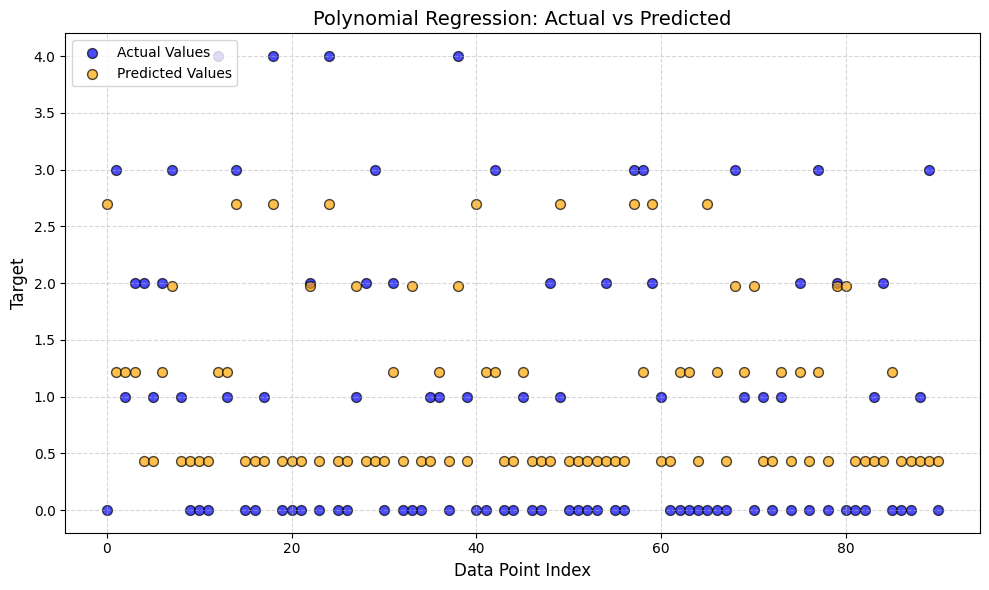

In [65]:
# Most correlated feature extraction
X_poly = (X[most_correlated_feature].values).reshape(-1, 1)

# Polynomial feature creation
poly_features = PolynomialFeatures(degree=2)
X_poly_transformed = poly_features.fit_transform(X_poly)

# Data splitting
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly_transformed, y.values, test_size=0.3, random_state=42)

# Training the model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_poly)

# Model Ealuation
y_pred_poly = poly_model.predict(X_test_poly)
poly_mse = sum((y_test_poly - y_pred_poly) ** 2) / len(y_test_poly)
print(f"Polynomial Regression Model Mean Squared Error (MSE): {poly_mse}\n")

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_poly)), y_test_poly, color='blue', edgecolor='black', alpha=0.7, label='Actual Values', s=50)
plt.scatter(range(len(y_test_poly)), y_pred_poly, color='orange', marker='o', edgecolor='black', alpha=0.7, label='Predicted Values', s=50)

plt.xlabel("Data Point Index", fontsize=12)
plt.ylabel("Target", fontsize=12)
plt.title("Polynomial Regression: Actual vs Predicted", fontsize=14)
plt.legend(fontsize=10, loc='upper left')  # Adjust legend size and position
plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid
plt.tight_layout()  # Improve spacing

plt.show()

Now, in this exercise, we do the polynomial regression based on the most correlated feature that we transform into its polynomial terms to increase its predictiveness. Compared to the results of linear models, the actual vs predicted plot shows that the polynomial model fits some of the data points closer. Still, many discrepancies remain, especially for the higher target values. This suggests that, while polynomial regression captures more complexity compared to the preceding model, it may still not fully capture the signal underlying the patterns, and additional tuning or more features could be helpful.

#Conclusion
These exercises have applied various forms of regression analyses, namely simple linear regression, multiple linear regression, logistic regression, and polynomial regression. In each of these models, different strengths and weaknesses appeared in the prediction of our target variable. The simplest—simple linear regression with only one feature—offered a basic, easy-to-interpret fit but could not capture the complexity in the data. Multiple linear regression used the top 5 correlated features to enhance accuracy, reducing the Mean Squared Error and providing a fairly balanced fit. However, it still struggled to capture the variability in target values. Logistic regression worked for classification, showing general patterns but misclassifying certain points, as it could not fully differentiate categories due to data overlap. Polynomial regression added non-linear terms, allowing it to capture more complex patterns. While it fit some data points better, there were still noticeable gaps, especially for higher values, and it risked overfitting with a limited data set.

In summary, multiple linear regression was the best fit overall, as it balanced simplicity and accuracy. Polynomial regression was more complex and captured non-linear patterns but did not fully solve the prediction issues. Additionally, adding more relevant features could improve accuracy across all models.